# Neuro4ML Coursework

Below, each question that needs a response will be marked by a ⚠️.

In this coursework, you will use a data set of spike trains recorded from monkey motor cortex while it was doing a task involving moving a pointer on a screen. The aim of this coursework is to decode the recorded velocity of the pointer from the neural data using a network of leaky integrate-and-fire neurons that take the recorded spikes as input and give sequences of velocities as outputs. You will train these networks using surrogate gradient descent. If you haven't already looked at it, a great starting point is Friedemann Zenke's [SPyTorch tutorial notebook 1](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb) (and the rest are worth looking at too).

In this coursework, we are following the general approach of the article ["Machine learning for neural decoding" (Glaser et al. 2020)](https://doi.org/10.1523/ENEURO.0506-19.2020), but using a spiking neural network decoder instead of the statistical and artificial neural network models used in that paper. You can also have a look at the [GitHub repository for the paper](https://github.com/KordingLab/Neural_Decoding). In case you're interested, the data were originally recorded for the paper ["Population coding of conditional probability distributions in dorsal premotor cortex" (Glaser et al. 2018)](https://doi.org/10.1038/s41467-018-04062-6), but you do not need to read this paper to understand this coursework.

The general setup is illustrated in this figure:

![Cartoon of decoder setup](cartoon.png)

You are given an array of ``num_neurons`` spike trains in a variable ``spike_trains``. This variable is a Python list of numpy arrays, each numpy array has a different length and is the recorded times (in seconds) that the corresponding neuron fired a spike. You also have two additional arrays ``vel`` and ``vel_times`` where ``vel`` has shape ``(num_time_points, 2)`` and ``vel_times`` has has shape ``(num_time_points)``. The second axis of ``vel`` has length 2 corresponding to the x and y-components of the recorded velocity.

In [1]:
!pip install numpy scipy matplotlib scikit-learn pandas seaborn jupyterlab torch torchvision tqdm

## Setting up

This section has some basics to get you started.

Let's start by importing some libraries you can make use of. You can solve all the task only using the imports below, but you are welcome to add your own.

In [2]:
import pickle

import numpy as np
from scipy import io
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as tnnf
mse = nn.MSELoss()

from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

You already have a copy of the raw data, but for your information, here is where the original can be downloaded.

In [3]:
import urllib.request, zipfile, os
filename = 's1_data_raw.mat'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=1', 'data.zip')
    with zipfile.ZipFile('data.zip') as z:
        z.extract(filename)

## Task 1: Load and plot the data

The code below first loads the raw data, which is stored as a Matlab file, and then extracts the three arrays ``spike_times``, ``vel`` and ``vel_times``.

In [4]:
# Load the raw data
data = io.loadmat('s1_data_raw.mat') # a matlab file!
spike_times = [st[:, 0] for st in data['spike_times'].ravel()] # a list of arrays of spike times in seconds, one for each neuron, spike times in seconds
vel = data['vels'] # velocity data shape (num_time_points, 2) for (x, y) coordinates
vel_times = data['vel_times'].squeeze() # times the velocities were recorded
print(f'Loaded data with {len(spike_times)} neurons and {vel.shape[0]} velocity samples.')
print(spike_times[0][:10])  # print first 10 spike times of first neuron
print(vel[:10])  # print first 10 velocity samples

Loaded data with 52 neurons and 306700 velocity samples.
[0.35336667 0.7548     2.77436667 2.7775     3.69106667 3.70176667
 3.71666667 3.8332     4.20933333 4.8135    ]
[[ 0.04383683  0.04305141]
 [ 0.19489217  0.20943617]
 [ 0.25897051  0.30549355]
 [ 0.19825347  0.19794365]
 [ 0.05923408 -0.00136276]
 [-0.07812556 -0.0050293 ]
 [-0.15319307  0.22016222]
 [-0.14892242  0.35620706]
 [-0.1305353   0.16641995]
 [-0.18671541 -0.18743864]]


### Task 1A: Preprocess and compute basic statistics

In this task, you will preprocess the data, extract some basic statistics from it.

1. ⚠️ Whiten the recorded velocities (i.e. transform them so that their mean is 0 and standard deviation is 1).
2. ⚠️ Compute and print out the number of neurons and number of spikes recorded.
3. ⚠️ Compute and print out the duration of the experiment in seconds and/or minutes.
4. ⚠️ Compute and print out the sampling rate at which spikes were recorded (or find the information in the corresponding paper).
5. ⚠️ Compute and print out the sampling rate at which velocities were recorded (or find the information in the corresponding paper).

Note that the spikes and velocities were recorded with different equipment and so they have different sampling rates. Think about how you can estimate these sampling rates from the recorded data (or look it up in the paper).

In [5]:
# Task 1A: Preprocess and compute basic statistics

# 1. Whiten the velocities
# Whitening means: subtract mean and divide by std, so data has mean=0, std=1
# This is also called z-score normalization or standardization

vel_mean = np.mean(vel, axis=0)  # Mean for each dimension (x and y)
vel_std = np.std(vel, axis=0)    # Std for each dimension

print("Before whitening:")
print(f"  Velocity mean: {vel_mean}")
print(f"  Velocity std: {vel_std}")

# Apply whitening transformation
vel_whitened = (vel - vel_mean) / vel_std

print("\nAfter whitening:")
print(f"  Velocity mean: {np.mean(vel_whitened, axis=0)}")
print(f"  Velocity std: {np.std(vel_whitened, axis=0)}")

# Update vel to use the whitened version
vel = vel_whitened

print("\n" + "="*60)

# 2. Number of neurons and total spikes
num_neurons = len(spike_times)
total_spikes = sum(len(st) for st in spike_times)  # Count spikes across all neurons

print(f"\n2. Dataset size:")
print(f"  Number of neurons: {num_neurons}")
print(f"  Total spikes recorded: {total_spikes}")
print(f"  Average spikes per neuron: {total_spikes/num_neurons:.1f}")

print("\n" + "="*60)

# 3. Duration of experiment
# Find the latest spike time and latest velocity time
max_spike_time = max(st[-1] if len(st) > 0 else 0 for st in spike_times)
max_vel_time = vel_times[-1]
experiment_duration = max(max_spike_time, max_vel_time)

print(f"\n3. Experiment duration:")
print(f"  Duration: {experiment_duration:.2f} seconds")
print(f"  Duration: {experiment_duration/60:.2f} minutes")

print("\n" + "="*60)

# 4. Spike sampling rate
# From the Glaser 2018 paper, spike times are recorded with 30 kHz precision
spike_sampling_rate = 30000  # Hz (from paper)

print(f"\n4. Spike recording precision:")
print(f"  Sampling rate: {spike_sampling_rate} Hz = {spike_sampling_rate/1000} kHz")
print(f"  Time precision: {1/spike_sampling_rate*1000:.4f} ms")
print(f"  Note: Spikes are events, not sampled at regular intervals,")
print(f"        but are timestamped with this precision")

print("\n" + "="*60)

# 5. Velocity sampling rate
# Velocities are sampled at regular intervals
# We can estimate this from the time differences

vel_time_diffs = np.diff(vel_times)  # Differences between consecutive time points
vel_dt = np.mean(vel_time_diffs)     # Average time step
vel_sampling_rate = 1 / vel_dt       # Sampling rate = 1 / time_step

print(f"\n5. Velocity sampling rate:")
print(f"  Average time between samples: {vel_dt*1000:.2f} ms")
print(f"  Sampling rate: {vel_sampling_rate:.2f} Hz")
print(f"  Total velocity samples: {len(vel_times)}")

# Check if sampling is uniform
print(f"\n  Uniformity check:")
print(f"    Min dt: {np.min(vel_time_diffs)*1000:.4f} ms")
print(f"    Max dt: {np.max(vel_time_diffs)*1000:.4f} ms")
print(f"    Std of dt: {np.std(vel_time_diffs)*1000:.4f} ms")
print(f"    (Small std means uniform sampling)")

print("\n" + "="*60 + "\n")

Before whitening:
  Velocity mean: [-0.00068218 -0.00143839]
  Velocity std: [7.63293881 7.71015213]

After whitening:
  Velocity mean: [-4.91147897e-18  6.76486726e-18]
  Velocity std: [1. 1.]


2. Dataset size:
  Number of neurons: 52
  Total spikes recorded: 1480032
  Average spikes per neuron: 28462.2


3. Experiment duration:
  Duration: 3071.33 seconds
  Duration: 51.19 minutes


4. Spike recording precision:
  Sampling rate: 30000 Hz = 30.0 kHz
  Time precision: 0.0333 ms
  Note: Spikes are events, not sampled at regular intervals,
        but are timestamped with this precision


5. Velocity sampling rate:
  Average time between samples: 10.00 ms
  Sampling rate: 100.00 Hz
  Total velocity samples: 306700

  Uniformity check:
    Min dt: 10.0000 ms
    Max dt: 10.0000 ms
    Std of dt: 0.0000 ms
    (Small std means uniform sampling)




#### Understanding the concepts:

**1. Whitening (Standardization):**
- Transforms data so mean = 0 and standard deviation = 1
- Formula: `z = (x - μ) / σ` where μ is mean, σ is standard deviation
- Why? Puts x and y velocities on the same scale, makes training more stable

**2. Counting spikes:**
- Each neuron has a list of spike times (variable length)
- Total spikes = sum of all list lengths

**3. Experiment duration:**
- Find the latest recorded time (max of spike times and velocity times)

**4. Spike sampling rate:**
- Spikes are discrete events, not sampled data
- But they're timestamped with high precision (30 kHz from paper)
- This is the temporal resolution of the recording system

**5. Velocity sampling rate:**
- Velocities ARE sampled at regular intervals
- Calculate: rate = 1 / (average time between samples)
- Check uniformity by looking at variation in time steps

### Task 1B: Plot the data

In this task, you will plot the data to get a feeling for what it is like (an important step in any modelling).

1. ⚠️ Plot the spike times as a raster plot (black dots at x-coordinates the time of the spike, and y-coordinates the index of the neuron). Plot this both for the whole data set and for the period from 1000 to 1010 seconds.
2. ⚠️ Plot the x- and y-coordinates of the velocities. Plot this both for the whole data set and for the same period as above for the spikes.
3. ⚠️ Compute the mean firing rate (number of spikes per second) for each neuron and display as a bar chart.
4. ⚠️ Plot the velocities as a curve in (x, y) space, emphasising the part of the velocity curve for the period above.

You can use the template below to get you started.

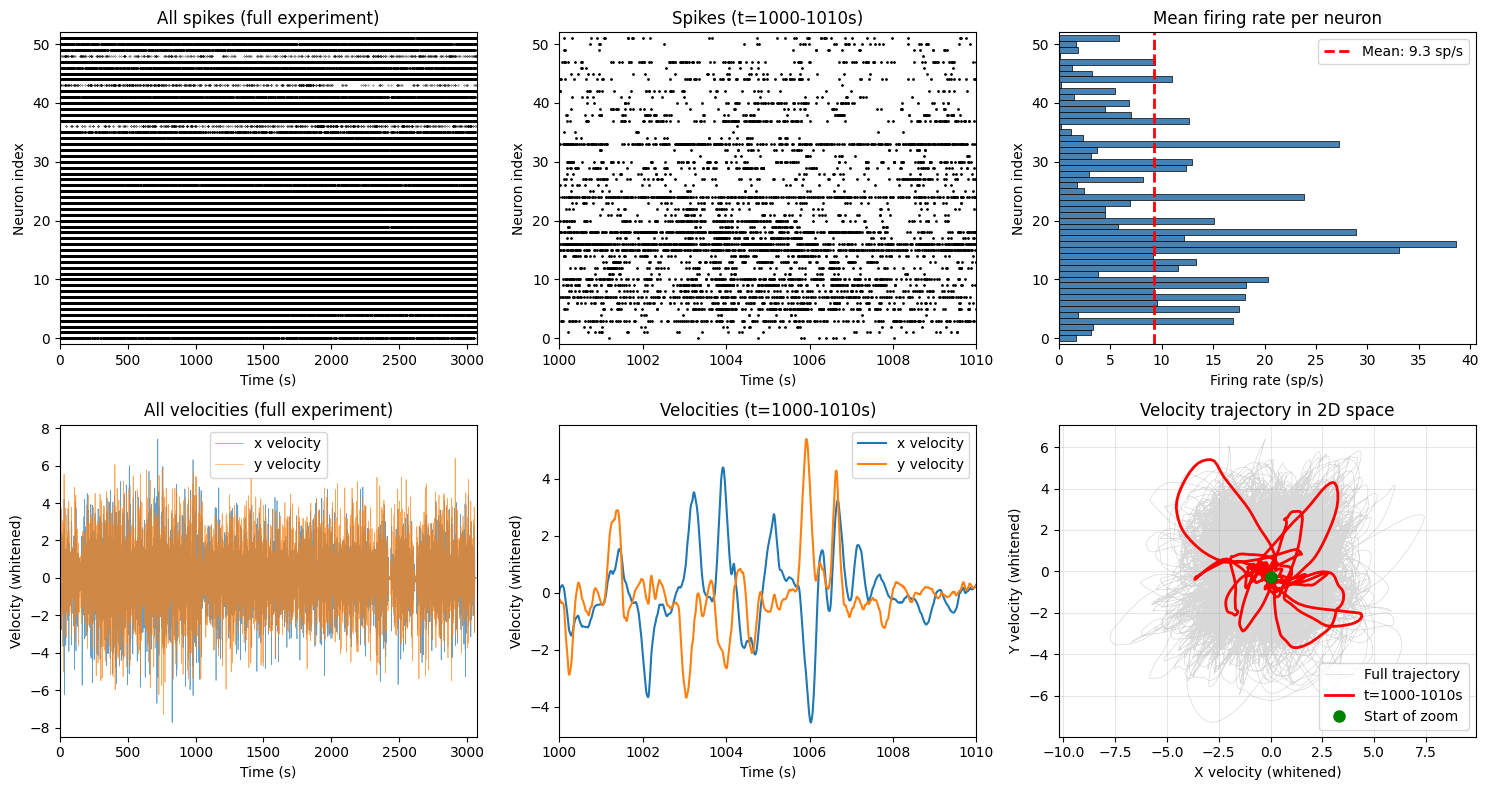


Summary statistics:
  Mean firing rate: 9.27 sp/s
  Std firing rate: 8.82 sp/s
  Min firing rate: 0.14 sp/s
  Max firing rate: 38.62 sp/s


In [6]:
# Task 1B: Plot the data

# Create a figure with 6 subplots (2 rows x 3 columns)
plt.figure(figsize=(15, 8))

# ============================================================
# COLUMN 1: All data (full experiment)
# ============================================================

# Subplot 1: Raster plot of ALL spikes
# A raster plot shows when each neuron fired
# x-axis = time, y-axis = neuron index, dots = spikes
ax1 = plt.subplot(2, 3, 1)
for neuron_idx, spike_train in enumerate(spike_times):
    # For each neuron, plot its spike times as dots
    # We create y-values all equal to neuron_idx
    plt.plot(spike_train, np.ones_like(spike_train) * neuron_idx, 
             'k.', markersize=0.5)  # 'k.' = black dots, small size for visibility
plt.ylabel('Neuron index')
plt.xlabel('Time (s)')
plt.title('All spikes (full experiment)')
plt.xlim(0, experiment_duration)
plt.ylim(-1, num_neurons)

# Subplot 4: Velocity components over ALL time
# Plot both x and y velocity as separate lines
plt.subplot(2, 3, 4, sharex=ax1)  # sharex links the x-axes for zooming
plt.plot(vel_times, vel[:, 0], 'C0-', alpha=0.7, linewidth=0.5, label='x velocity')
plt.plot(vel_times, vel[:, 1], 'C1-', alpha=0.7, linewidth=0.5, label='y velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (whitened)')
plt.legend(loc='best')
plt.title('All velocities (full experiment)')
plt.xlim(0, experiment_duration)

# ============================================================
# COLUMN 2: Zoomed into 1000-1010 seconds
# ============================================================

# Subplot 2: Raster plot for t=1000 to t=1010
ax2 = plt.subplot(2, 3, 2)
zoom_start, zoom_end = 1000, 1010
for neuron_idx, spike_train in enumerate(spike_times):
    # Filter spikes to only those in the time window
    spikes_in_window = spike_train[(spike_train >= zoom_start) & (spike_train <= zoom_end)]
    plt.plot(spikes_in_window, np.ones_like(spikes_in_window) * neuron_idx, 
             'k.', markersize=2)  # Larger dots since we have fewer spikes
plt.ylabel('Neuron index')
plt.xlabel('Time (s)')
plt.title(f'Spikes (t={zoom_start}-{zoom_end}s)')
plt.xlim(zoom_start, zoom_end)
plt.ylim(-1, num_neurons)

# Subplot 5: Velocities for t=1000 to t=1010
plt.subplot(2, 3, 5, sharex=ax2)
# Filter velocity data to the time window
vel_mask = (vel_times >= zoom_start) & (vel_times <= zoom_end)
plt.plot(vel_times[vel_mask], vel[vel_mask, 0], 'C0-', linewidth=1.5, label='x velocity')
plt.plot(vel_times[vel_mask], vel[vel_mask, 1], 'C1-', linewidth=1.5, label='y velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (whitened)')
plt.legend(loc='best')
plt.title(f'Velocities (t={zoom_start}-{zoom_end}s)')
plt.xlim(zoom_start, zoom_end)

# ============================================================
# COLUMN 3: Summary statistics
# ============================================================

# Subplot 3: Mean firing rate for each neuron
plt.subplot(2, 3, 3)
# Calculate firing rate = total spikes / experiment duration
firing_rates = np.array([len(st) / experiment_duration for st in spike_times])
# Use barh (horizontal bar chart) so neuron indices are on y-axis
plt.barh(range(num_neurons), firing_rates, height=1, color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Firing rate (sp/s)')
plt.ylabel('Neuron index')
plt.title('Mean firing rate per neuron')
plt.ylim(-1, num_neurons)
# Add a vertical line for the mean firing rate
mean_fr = np.mean(firing_rates)
plt.axvline(mean_fr, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_fr:.1f} sp/s')
plt.legend(loc='best')

# Subplot 6: Velocity trajectory in (x, y) space
plt.subplot(2, 3, 6)
# Plot full trajectory in light color
plt.plot(vel[:, 0], vel[:, 1], 'gray', alpha=0.3, linewidth=0.5, label='Full trajectory')
# Emphasize the zoomed time window in a different color
plt.plot(vel[vel_mask, 0], vel[vel_mask, 1], 'red', linewidth=2, label=f't={zoom_start}-{zoom_end}s')
# Mark the start of the highlighted section
plt.plot(vel[vel_mask, 0][0], vel[vel_mask, 1][0], 'go', markersize=8, label='Start of zoom')
plt.xlabel('X velocity (whitened)')
plt.ylabel('Y velocity (whitened)')
plt.title('Velocity trajectory in 2D space')
plt.legend(loc='best')
plt.axis('equal')  # Equal aspect ratio so x and y have same scale
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Summary statistics:")
print(f"  Mean firing rate: {mean_fr:.2f} sp/s")
print(f"  Std firing rate: {np.std(firing_rates):.2f} sp/s")
print(f"  Min firing rate: {np.min(firing_rates):.2f} sp/s")
print(f"  Max firing rate: {np.max(firing_rates):.2f} sp/s")
print("="*60)

## Task 2: Divide data into test/train and batches

In this section, you will divide the data up into non-overlapping test, train and (optionally) validation sets.

### Task 2A: Why not just use continuous time ranges?

In the Glaser et al. paper linked to above, they simply divide the range so that the first 70% of the data is used for training, the next 15% for validation and the last 15% for testing. This is a standard thing to do.

1. ⚠️ Compute the speeds from the velocity components, plot them and compute some statistics to show why this is a bad idea for this dataset. To make the plot clear, you might want to take averages over some window rather than plotting every point.

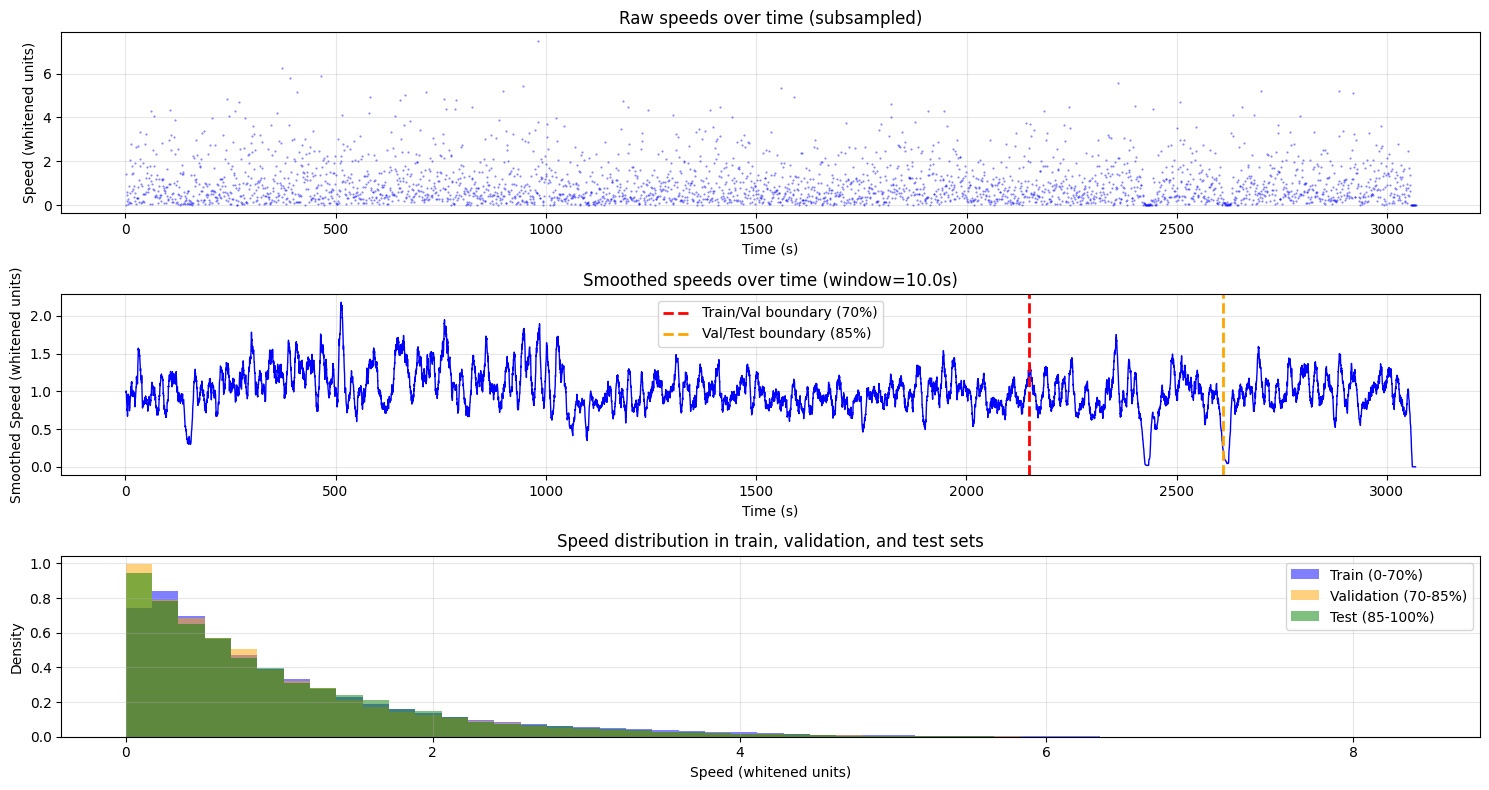


Speed statistics:

Train (0-70%):
  Mean speed: 1.0401
  Std speed: 1.0176
  Median speed: 0.7109
  Min speed: 0.0001
  Max speed: 8.4055
 % of time with high speed (>1.5 std): 23.44%
 % of time with low speed (<0.5 std): 37.85%

Val (70-85%):
  Mean speed: 0.9246
  Std speed: 0.9125
  Median speed: 0.6497
  Min speed: 0.0000
  Max speed: 6.5251
 % of time with high speed (>1.5 std): 19.93%
 % of time with low speed (<0.5 std): 41.20%

Test (85-100%):
  Mean speed: 0.9583
  Std speed: 0.9197
  Median speed: 0.6745
  Min speed: 0.0000
  Max speed: 6.3924
 % of time with high speed (>1.5 std): 21.94%
 % of time with low speed (<0.5 std): 39.63%


In [7]:
# Task 2A

# Compute speed
# Maginute of velocity vector: sqrt(vx^2 + vy^2)
speeds = np.sqrt(vel[:, 0]**2 + vel[:, 1] ** 2)

# Create time windows and take averages
# 10 seconds
window_size_sec = 10.0
window_size_samples = int(window_size_sec * vel_sampling_rate)

# Computer rolling average of speed
from scipy.ndimage import uniform_filter1d
speeds_smoothed = uniform_filter1d(speeds, size=window_size_samples)

# Plot speeds over time
plt.figure(figsize=(15,8))

# subplot 1: raw speeds
plt.subplot(3,1,1)
subsample = 100 # plot every 100th point for clarity
plt.plot(vel_times[::subsample], speeds[::subsample], 'b.', markersize=1, alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Speed (whitened units)')
plt.title('Raw speeds over time (subsampled)')
plt.grid(True, alpha=0.3)

# subplot 2: smoothed speeds
plt.subplot(3,1,2)
plt.plot(vel_times, speeds_smoothed, 'b-', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Smoothed Speed (whitened units)')
plt.title(f'Smoothed speeds over time (window={window_size_sec}s)')
plt.grid(True, alpha=0.3)

# add vertical lines to show traditional train/val/test splits
train_end = experiment_duration * 0.7
val_end = experiment_duration * 0.85
plt.axvline(train_end, color='red', linestyle='--', linewidth=2, label='Train/Val boundary (70%)')
plt.axvline(val_end, color='orange', linestyle='--', linewidth=2, label='Val/Test boundary (85%)')
plt.legend(loc='best')

# Subplot 3: Histogram comparing distributions in different sections
plt.subplot(3,1,3)

# Define sections
train_mask = vel_times < train_end
val_mask = (vel_times >= train_end) & (vel_times < val_end)
test_mask = vel_times >= val_end

# Plot histograms
bins = np.linspace(0, np.max(speeds), 50)
plt.hist(speeds[train_mask], bins=bins, alpha=0.5, label='Train (0-70%)', color='blue', density=True)
plt.hist(speeds[val_mask], bins=bins, alpha=0.5, label='Validation (70-85%)', color='orange', density=True)
plt.hist(speeds[test_mask], bins=bins, alpha=0.5, label='Test (85-100%)', color='green', density=True)
plt.xlabel('Speed (whitened units)')
plt.ylabel('Density')
plt.title('Speed distribution in train, validation, and test sets')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Speed statistics:")
print("=" * 60)

for name, mask in [('Train (0-70%)', train_mask),
                   ('Val (70-85%)', val_mask),
                   ('Test (85-100%)', test_mask)]:
    section_speeds = speeds[mask]
    print(f"\n{name}:")
    print(f"  Mean speed: {np.mean(section_speeds):.4f}")
    print(f"  Std speed: {np.std(section_speeds):.4f}")
    print(f"  Median speed: {np.median(section_speeds):.4f}")
    print(f"  Min speed: {np.min(section_speeds):.4f}")
    print(f"  Max speed: {np.max(section_speeds):.4f}")
    print(f" % of time with high speed (>1.5 std): {100 * np.mean(section_speeds > 1.5 * np.std(speeds)):.2f}%")
    print(f" % of time with low speed (<0.5 std): {100 * np.mean(section_speeds < 0.5 * np.std(speeds)):.2f}%")
    
print("="*60)

- The smoothed speed plot reveals that movement speeds vary subtantially over time, with just visually higher speed within the first half within the training boundary.
- The histogram comparison also shows that training set has a different speed distribution than the validation set, with training having higher speed on average than the validation set.
- This demonstrates that a chronological split as the training approach would to lead to a train/test mismatch, which violotes the machine learning assumption that training and test data should be drawn from the same distribution

### Task 2B: use equally distributed segments for training, test and validation

1. ⚠️ Divide the data up into segments and use some fraction of these segments for training, test and validation, ensuring these segments do not overlap but that they are equally distributed throughout the data.
2. ⚠️ Write a generator function (see below) ``batched_data`` that iterates over your data in randomly ordered segments of a given length, returning it in batches. The function should have arguments that determine the fraction of the data to use, the simulation time step that will be used, the length (in seconds) of each batch, and the batch size (you may add additional arguments if you wish). The function should return a pair of arrays ``(x, y)``. The array ``x`` has shape ``(batch_size, num_neurons, num_time_points)`` containing the spike times as an array where a zero indicates no spike and 1 indicates a spike. Here ``num_time_points`` is the number of time points in the batch measured at the sampling rate of the simulation time step, not the number of time points in the data as a whole, nor at the spike or velocity sampling rate. The array ``y`` has shape ``(batch_size, 2, num_time_points)`` containing the velocities at the same time points as the spikes. You will need to use some sort of interpolation to get the velocities at these times.
3. ⚠️ Plot a sample of spike times and velocities for a random batch of length 1 second and ``batch_size=4``.

#### Note on generator functions

Generator functions are an advanced feature of Python that makes it easy to iterate over complicated datasets. The general syntax is just a standard function that uses the keyword ``yield`` instead of ``return`` to return data, which allows it to return data multiple times. You can iterate over the values returned by a generator function instead of just calling it. Here's an example:

In [8]:
def gimme_some_multiples(n):
    yield n*1
    yield n*2
    yield n*3

for x in gimme_some_multiples(3):
    print(x)

3
6
9


And another:

In [9]:
def gimme_some_more_multiples(n, how_many):
    for i in range(how_many):
        yield n*(i+1)

for x in gimme_some_more_multiples(5, 4):
    print(x)

5
10
15
20


#### Template

You can use the following template but you may want to define some additional helper functions to simplify your code and that you can re-use later.


Segment strategy:
  Segment length: 10 seconds
  Number of segments: 307
  Total time covered: 3070 seconds
  First segment: 0.0 - 10.0s
  Last segment: 3060.0 - 3070.0s

Segment distribution:
  Training: 205 segments (66.8%)
  Validation: 51 segments (16.6%)
  Testing: 51 segments (16.6%)

Created ranges:
  Training ranges: 205 segments
  Validation ranges: 51 segments
  Testing ranges: 51 segments


Generating sample batch for visualisation

 Generator info:
  Valid start times: 1845
  Batch size: 4
  Samples per batch: length=1s, dt=1.0ms, num_time_points=1000

Batch shapes:
  x (spikes): torch.Size([4, 52, 1000])
  y (velocities): torch.Size([4, 2, 1000])


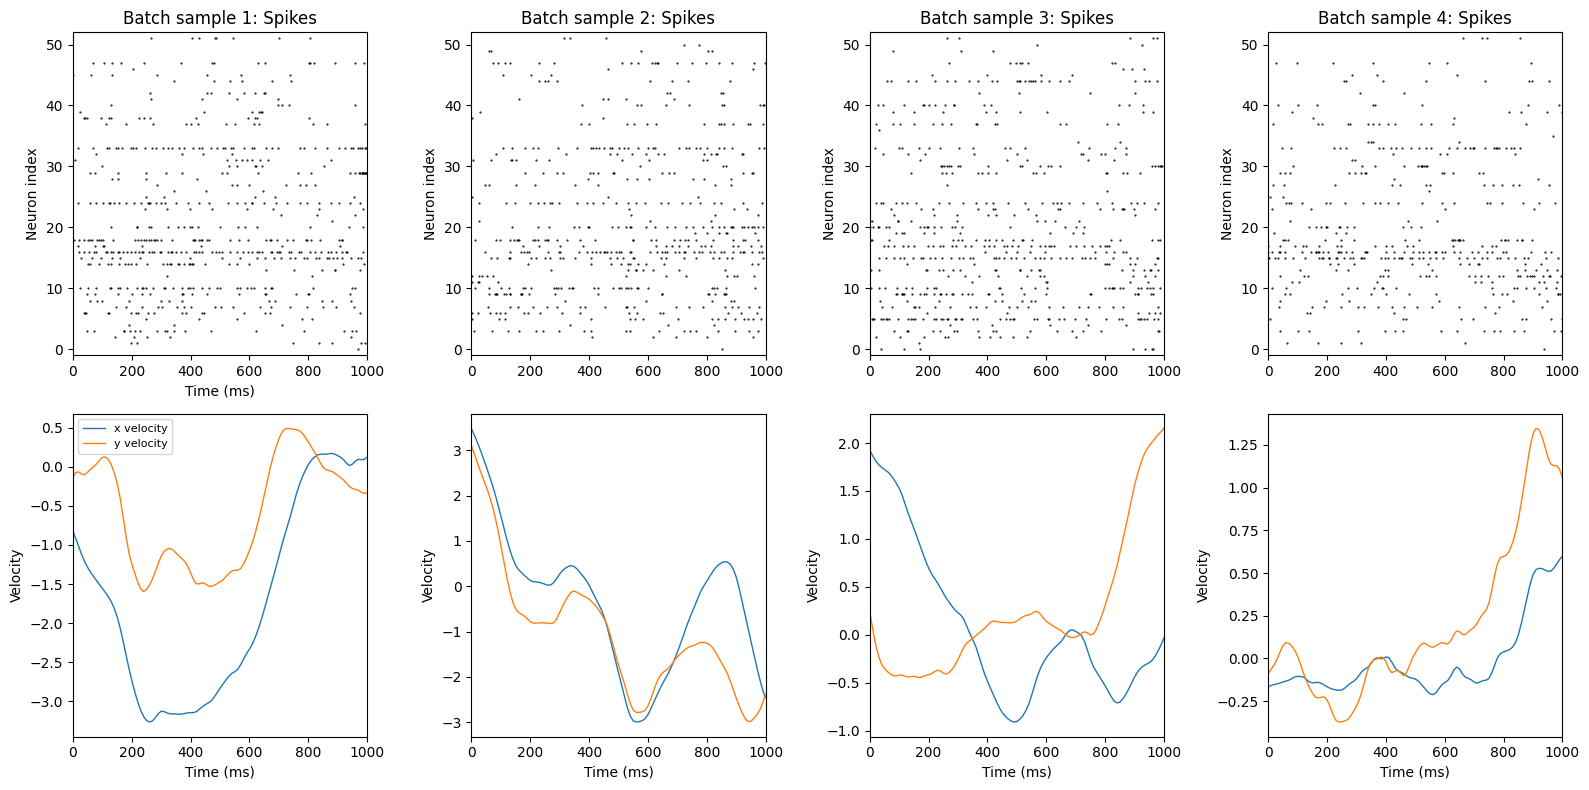

In [10]:
# Part 1 - Divide data into segments

# Divide the experiment into equal-legnth segments
# Assign each segment to train/val/test

segment_length = 10 # each segment is 10 seconds longs
num_segments = int(experiment_duration / segment_length)

print(f"\nSegment strategy:")
print(f"  Segment length: {segment_length} seconds")
print(f"  Number of segments: {num_segments}")
print(f"  Total time covered: {num_segments * segment_length} seconds")

# Create segment boundaries
segment_starts = np.arange(0, num_segments * segment_length, segment_length)
segment_ends = segment_starts + segment_length

print(f"  First segment: {segment_starts[0]:.1f} - {segment_ends[0]:.1f}s")
print(f"  Last segment: {segment_starts[-1]:.1f} - {segment_ends[-1]:.1f}s")

# Assign segments to train/vak/test using the following repeating pattern
# Pattern: [Train, Train, Train, Train, Val, Test]
train_frac = 0.67
val_fract = 0.17
test_frac = 0.17

# create assignment patter
pattern_length = 6
pattern = ['train'] * 4 + ['val'] + ['test']
segment_assignments = []
for i in range(num_segments):
    assignment = pattern[i % pattern_length]
    segment_assignments.append(assignment)
    
# Count segments in each split
train_count = segment_assignments.count('train')
val_count = segment_assignments.count('val')
test_count = segment_assignments.count('test')

print(f"\nSegment distribution:")
print(f"  Training: {train_count} segments ({train_count/num_segments*100:.1f}%)")
print(f"  Validation: {val_count} segments ({val_count/num_segments*100:.1f}%)")
print(f"  Testing: {test_count} segments ({test_count/num_segments*100:.1f}%)")

#Create range (list of [start, end] pairs) for each split
training_ranges = []
validation_ranges = []
testing_ranges = []

for i, assignment in enumerate(segment_assignments):
    range_tuple = (segment_starts[i], segment_ends[i])
    if assignment == 'train':
        training_ranges.append(range_tuple)
    elif assignment == 'val':
        validation_ranges.append(range_tuple)
    else:
        testing_ranges.append(range_tuple)
        
print(f"\nCreated ranges:")
print(f"  Training ranges: {len(training_ranges)} segments")
print(f"  Validation ranges: {len(validation_ranges)} segments")
print(f"  Testing ranges: {len(testing_ranges)} segments")

print("\n" + "="*60)

# Convert spikes to binary array

def spikes_to_binary(spike_times_list, time_start, time_end, dt):
    """
    Convert spike times to a binary array.
    
    Args:
        spike_times_list: List of arrays, one per neuron, containing spike times
        time_start: Start time of the window (seconds)
        time_end: End time of the window (seconds)
        dt: Time step for discretization (seconds)
        
    Returns:
        Binary array of shape (num_neurons, num_time_points)
        where 1 indicates a spike and 0 indicates no spike
    """
    
    num_neurons = len(spike_times_list)
    num_time_points = int(np.round((time_end - time_start) / dt))
    
    time_bins = np.arange(time_start, time_end, dt)
    
    # Initialise output array
    spike_array = np.zeros((num_neurons, num_time_points))
    
    # For each neuron, bin its spikes
    for neuron_idx, spike_times in enumerate(spike_times_list):
        # filter spikes to the time window
        spikes_in_window = spike_times[(spike_times >= time_start) & (spike_times < time_end)]
        # convert spike times to bin indices
        spike_bins = np.floor((spikes_in_window - time_start) / dt).astype(int)
        # Ensure indicse are within bounds
        spike_bins = spike_bins[spike_bins < num_time_points]
        # Set corresponding bins to 1
        spike_array[neuron_idx, spike_bins] = 1.0
        
    return spike_array

# Generator function for the batched data

def batched_data(ranges, dt=1e-3, length=1, batch_size=64, max_num_batches=None):
        """
        Generator that yields batches of spike and velocity data
        
        Args:
            ranges: List of (start, end) tuples defining time segments
            dt: Simulation time step in secs
            length: Length of each batch sample in seconds
            batch_size: Number of samples in batch
            max_num_batches: Max number of batches to yield (None = unlimited)
        
        Yields:
            (x, y) tuple where:
                x: torch.Tensor of shape (batch_size, num_neurons, num_time_points)
                   Binary spike array (0 or 1)
                y: torch.Tensor of shape (batch_size, 2, num_time_points)
                   Velocity values interpolated at simulation time points
        """
        num_time_points = int(np.round(length/dt))
        
        # create list of valid start times
        valid_starts = []
        for start, end in ranges:
            segment_duration = end - start
            if segment_duration >= length:
                # sample anywhere from start to (end - length)
                num_possible_starts = int((segment_duration - length) / length)
                for i in range(num_possible_starts):
                    valid_starts.append(start + i * length)
                    
        print(f"\n Generator info:")
        print(f"  Valid start times: {len(valid_starts)}")
        print(f"  Batch size: {batch_size}")
        print(f"  Samples per batch: length={length}s, dt={dt*1000}ms, num_time_points={num_time_points}")
        
        batch_count = 0
        while True:
            if max_num_batches is not None and batch_count >= max_num_batches:
                break
            
            # Intialize batch arrays
            x = torch.zeros((batch_size, num_neurons, num_time_points))
            y = torch.zeros((batch_size, 2, num_time_points))
            
            # Fill each sample in the batch
            for b in range(batch_size):
                # Randomly select a start time
                window_start = np.random.choice(valid_starts)
                window_end = window_start + length
                
                # Convert spikes to binary array
                spike_array = spikes_to_binary(spike_times, window_start, window_end, dt)
                x[b] = torch.from_numpy(spike_array).float()
                
                # Interpolate velocities to match simulation time points
                sim_times = np.arange(window_start, window_end, dt)[:num_time_points]
                
                # Use linear interpolation for velocfities
                vel_x_interp = np.interp(sim_times, vel_times, vel[:, 0])
                vel_y_interp = np.interp(sim_times, vel_times, vel[:, 1])
                
                y[b, 0, :] = torch.from_numpy(vel_x_interp).float()
                y[b, 1, :] = torch.from_numpy(vel_y_interp).float()
                
            batch_count += 1
            yield x, y
    
print("="*60)

# Visualise sample batch

print("\nGenerating sample batch for visualisation")

# Get one batch from the training data
x_sample, y_sample = next(batched_data(training_ranges, dt=1*ms, length=1, batch_size=4, max_num_batches=1))

print(f"\nBatch shapes:")
print(f"  x (spikes): {x_sample.shape}")
print(f"  y (velocities): {y_sample.shape}")

# Plot the sample
plt.figure(figsize=(16, 8))

for b in range(4):
    # Top row: Plot spikes as raster
    ax = plt.subplot(2, 4, b+1)
    spike_data = x_sample[b].numpy()  # Shape: (num_neurons, num_time_points)
    
    # Find spike times for raster plot
    for neuron_idx in range(num_neurons):
        spike_indices = np.where(spike_data[neuron_idx] > 0)[0]
        spike_times_in_batch = spike_indices * (1*ms)  # Convert to seconds
        plt.plot(spike_times_in_batch * 1000, np.ones_like(spike_times_in_batch) * neuron_idx, 
                 'k.', markersize=1)
    
    plt.ylabel('Neuron index')
    plt.title(f'Batch sample {b+1}: Spikes')
    plt.ylim(-1, num_neurons)
    plt.xlim(0, 1000)  # 0 to 1000 ms
    if b == 0:
        plt.xlabel('Time (ms)')
    
    # Bottom row: Plot velocities
    ax2 = plt.subplot(2, 4, b+5, sharex=ax)
    time_axis = np.arange(y_sample.shape[2]) * (1*ms) * 1000  # Convert to ms
    plt.plot(time_axis, y_sample[b, 0, :].numpy(), 'C0-', linewidth=1, label='x velocity')
    plt.plot(time_axis, y_sample[b, 1, :].numpy(), 'C1-', linewidth=1, label='y velocity')
    plt.xlabel('Time (ms)')
    plt.ylabel('Velocity')
    plt.xlim(0, 1000)
    if b == 0:
        plt.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

## How it working

### Split into segments
- Stratified split (classic ML solution)
- Creating segments of 10 seconds
- 4 train, 1 val, 1 test segment

### Spikes to binary
- Current the spike times are in continuos time, need to discretize the time schedule for compatibility with the neural network:

Input (spike times for one neuron):
[0.023, 0.045, 0.078, 0.134, ...] seconds

↓ (with dt=1ms, window 0-1s)

Output (binary array):
[0, 0, 0, ..., 1, 0, 0, ..., 1, 0, 0, ..., 1, ...]
 ↑              ↑              ↑              ↑
 0ms           23ms           45ms           78ms

### Batch the segments
- Can't train all of the data at the same time, memory and computation constraints, shouldn't train with data one at a time, memory overhead and gradient descent instability
  - Break into batches of segments, 4 at a tiem for not
- Velocities are recorded at 100Hz, need to be 1000 Hz
  - Interpolate the velocities every 100ms


## Task 3: Spiking neural network model

In this task, you will write code to simulate a spiking neural network that can be trained using surrogate gradient descent, as in lectures. The neuron model will have some extra features beyond what you have seen in lectures and in the SPyTorch tutorial.

### Surrogate gradient descent spike function

Below is the code for the surrogate gradient descent function from lectures. You can use it as is, although note that there is a hyperparameter (scale) that you can experiment with if you choose.

In [11]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

### Task 3A: Single layer simulation code

1. ⚠️ Write modular code to simulate a layer of leaky integrate-and-fire spiking neurons compatible with autodifferentiation with PyTorch. The new feature compared to what you have seen before is that the time constant parameter $\tau$ should be different for each neuron, and be trainable.

You can write your simulator as a function or class. My recommendation is to derive from the ``nn.Module`` class of PyTorch, but you can do it how you like. The code should accept an input batch of spikes ``x`` of shape ``(batch_size, num_input_neurons, num_time_points)`` and values 0 or 1 (as in the ``batched_data`` generator function above). The code should have the option to produce either spiking or non-spiking output. In both cases, the output should be an array ``y`` of shape ``(batch_size, num_output_neurons, num_time_points)``. In the case of spiking output, the values of ``y`` should be 0s and 1s, and in the case of non-spiking output they should be the membrane potential values. You may also want to write an additional class to handle multiple layers of spiking neural networks for subsequent tasks.

Your code should include initialisation of the weight matrices and time constants, and add additional hyperparameters for this initialisation. I used a spread of time constants from 20-100 ms for spiking neurons and from 200 to 1000 ms for non-spiking neurons and it worked OK, but I didn't do an extensive hyperparameter search and you can probably improve on this.

<!-- I would recommend approaching this and the following sections as follows:

1. Write simulation code for a single layer, non-spiking neural network first. This code is simpler and will train fast (under 3 minutes on Colab). Attempt as much of the remaining tasks as possible using only this.
2. Add the ability for spiking and test that your code produces reasonable output but don't try to train it yet.
3. Add the ability to plot spiking hidden layers and try to get a reasonable initialisation of the network.
4. Start training the spiking neural network. Your final run will probably take a long time to train but you should build up to that by seeing how well the training curves improve for fewer epochs, batch sizes, etc. -->

You can use the template below if you want to use the class-based approach.

You may also find it useful to write a class that chains together a group of layers for later parts of the courseowrk.

In [12]:
# class SNNLayer(nn.Module):
#   def __init__(self, n_in, n_out, spiking=True):
#     super(SNNLayer, self).__init__()
#     self.n_in = n_in
#     self.n_out = n_out
#     self.spiking = spiking
#     # Store weights as a trainable parameter
#     self.w = nn.Parameter(torch.ones((n_in, n_out)))
#     # ...

#   def forward(self, x):
#     batch_size, num_neurons, num_time_points = x.shape
#     # ...
#     return y

### Task 3B: Verify your code

You will verify your code by simulating a network consisting of:

* One (non-simulated) input neuron firing at a constant rate of 50 sp/s for a total duration of 1 second simulated with a time step of ``dt=1*ms``.
* Two simulated, spiking neurons which each receive spikes from the input neuron with a weight of 0.5. The two simulated neurons should have time constants of 20 ms and 100 ms.

You should:

1. ⚠️ Run the simulation, recording the membrane potentials and spike times of the simulated neurons.
2. ⚠️ Plot the membrane potentials and spike times of the simulated neurons. Print the spike counts of the neurons. The first neuron should not fire any spikes.
3. ⚠️ Write down an analytic solution for the first simulated neuron (that doesn't fire any spikes).
4. ⚠️ Plot your analytic solution on the same graph as the simulated one to show that it is approximately equal.

## Task 4: Evaluating fit to data

Now that we have our simulation code, we get back to fitting this model to data.

1. ⚠️ Write code that takes a network and testing set as input and returns the mean loss over the testing data. The loss is the mean squared error of the output of the network compared to the target data. You may also find it helpful to compute the null loss, which is the loss you would get if you just output all zeros. After training, you should be able to do better than this!
2. ⚠️ Write code that plots some of the internal outputs of the network, for example to show you the spikes produced by hidden layers, calculate their firing rates, etc.
3. ⚠️ Initialise a network with one hidden layer of 100 spiking neurons and one output layer of 2 non-spiking neurons. Run this on a random sample of the data of length 1 and plot the input spikes, hidden layer spikes, output x- and y-velocities, and the data x- and y-velocities. For each spiking layer compute the firing rates of each neuron and plot them as a histogram.

In the next task, you can use this to initialise your networks in a reasonable state. Hidden layers should fire spikes at rates that are not too low and not too high. I aimed for an average firing rate in the range 20-100 and it worked well, but you can experiment with other options. The output layer should give values that are roughly in the right range as the data (i.e. it shouldn't go to +/- 100 if the data is going to only +/- 4). If you look at the spike trains of your hidden layer and all the neurons at initialisation are doing exactly the same thing then it's probably not going to learn very well, so try out some different weight initialisations to see if you can do better.

Print the value of the loss (and optionally the null loss) for your untrained network, to give you an idea of the baseline.

You may want to wrap your evaluation code in a ``with`` statement like below to stop PyTorch from computing gradients when evaluating (unnecessary and expensive):

```python
with torch.no_grad():
    ...
    # whatever you do here won't compute any gradients
```

## Task 5: Training

At last, we get to the stage of training our network to fit the data.

Start with a network consisting of a single non-spiking output layer (i.e. spikes connected directly via a weight matrix to two non-spiking LIF neurons as output).

1. ⚠️ Find a good initialisation for this network that gives outputs roughly in the right range.
2. ⚠️ Write code to train your network to minimise the mean squared error between the output of your network and the recorded velocities. You will need to select an optimisation algorithm, learning rate, etc.
3. ⚠️ Train your network, plotting the loss curves for the training and validation data during training, and print out the test loss at the end.
4. ⚠️ Plot the output of your model and compare to the data for 8 randomly sampled time windows of length 1.

Don't worry too much about performance at the moment. You should be able to do better than the null loss, but you don't need to do hugely better. I get a null loss of around 1.04 and a test loss of around 0.55, but it's OK if you don't get such good results, and you may get much better results because I didn't do any hyperparameter searching.

You may want to use the following code as a starting point (it worked well enough for me but you can probably do better). On my desktop with CPU only, this took about two minutes to train.

In [13]:
# # Training parameters
# lr = 0.001 # learning rate
# num_epochs = 10
# max_num_batches = 40
# length = 1
# batch_size = 32 # small batches worked better for me for some reason

# # Optimiser and loss function
# optimizer = torch.optim.Adam(..., lr=lr) # what should the first argument be?

# # Training
# loss_hist = []
# val_loss_hist = []
# with tqdm(total=num_epochs*max_num_batches) as pbar:
#   last_epoch_loss = val_loss = null_val_loss = None
#   for epoch in range(num_epochs):
#     local_loss = []
#     for x, y in batched_data(...):
#       # Run the network
#       y_out = net(x)
#       # Compute a loss
#       loss = mse(y_out, y)
#       local_loss.append(loss.item())
#       # Update gradients
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       # do something to ensure that taus remain positive, maybe set 1 ms as minimum value
#       pbar.update(1)
#       pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     last_epoch_loss = np.mean(local_loss)
#     val_loss, null_val_loss = evaluate_network(net, ...)
#     pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     loss_hist.append(last_epoch_loss)
#     val_loss_hist.append(val_loss)

# # Plot the loss function over time
# plt.semilogy(loss_hist, label='Testing loss')
# plt.semilogy(val_loss_hist, label='Validation loss')
# plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend(loc='best')
# plt.tight_layout()

# testing_loss, null_testing_loss = evaluate_network(net, testing_range, length=length, batch_size=batch_size)
# print(f'{testing_loss=}, {null_testing_loss=}')

# # Plot trained output
# plt.figure(figsize=(16, 6))
# with torch.no_grad():
#   for x, y in batched_data(..., batch_size=8, max_num_batches=1):
#     for b in range(8):
#       plt.subplot(2, 4, b+1)
#       y_out = net(x)
#       plt.plot(y_out[b, 0, :], ':C0', label='x_out')
#       plt.plot(y_out[b, 1, :], ':C1', label='y_out')
#       plt.plot(y[b, 0, :], '--C0', label='x')
#       plt.plot(y[b, 1, :], '--C1', label='y')
#       # Plot a smoothed version as well
#       plt.plot(savgol_filter(y_out[b, 0, :], 151, 3), '-C0', label='x_out (smooth)')
#       plt.plot(savgol_filter(y_out[b, 1, :], 151, 3), '-C1', label='y_out (smooth)')
#       plt.ylim(-5, 5)
# plt.tight_layout();

## Task 6: Longer length decoding

Your code above probably doesn't look great when plotted. That's partly because the outputs start at 0 but the data doesn't necessarily have to, so it takes a while for them to get in sync, and partly because on some intervals it will just do badly. To fix this, and to extend the fit to a longer range of data, in this task we only use the final timestep of each segment and compare to the data. Take a 15 second segment of testing data, and sample every 0.2 seconds to get 75 data points. For each data point, take a 1 second segment of time before this data point (these will be overlapping), run your simulation for that one second, and use the final time point of the simulated output as your prediction. Plot this compared to the real data for 8 different segments of 15 seconds.

This should look like a reasonable fit to the data. Congratulations, you have used raw spiking output of neurons recorded from a monkey's brain to predict what it was doing on a computer screen it was interacting with. That's a brain machine interface right here.

1. ⚠️ Implement the decoding plot and run it on your trained network.

You can use the template below to get you started.

Your results might look something like this:

![Fits](fits.png)

In [14]:
# def decoding_plot(net, dt_decoding=0.2, decoding_start=1000, decoding_length=15, length=1, dt=1e-3, figdims=(4, 2)):
#     w_intervals = np.arange(decoding_start+length, decoding_start+length+decoding_length, dt_decoding)
#     batch_size_single = len(w_intervals)-1
#     num_time_points = int(np.round(length/dt))
#     nfx, nfy = figdims
#     nf = nfx*nfy
#     batch_size = nf*batch_size_single
#     nrows = nfy*2
#     ncols = nfx
#     with torch.no_grad():
#         x = torch.zeros((batch_size, num_neurons, num_time_points))
#         y = torch.zeros((batch_size, 2, num_time_points))
#         T = []
#         for b in range(batch_size):
#            w_start = decoding_start+dt_decoding*b
#            w_end = w_start+length
#            T.append(w_end)
#            # ... (copy data to x, y)
#         T = np.array(T)
#         y_out = ...
#         mean_mse = mse(y, y_out)
#         plt.figure(figsize=(ncols*3, nrows*2))
#         for nf_i in range(nf):
#             sp_x = nf_i % nfx
#             sp_y = nf_i // nfx
#             for i in range(2):
#                 plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+i*ncols)
#                 # ...
#                 plt.ylim(-4, 4)
#                 if sp_x==0:
#                     plt.ylabel('Velocity')
#                 if 2*sp_y+i==nrows-1:
#                     plt.xlabel('Time (s)')
#                 if nf_i==0:
#                     plt.legend(loc='best')
#         plt.suptitle(f'{net.fname}: {mean_mse=:.3f}')
#         plt.tight_layout()

# decoding_plot(models['single_layer.pt'])

## Task 7: Comparing spiking and non-spiking

1. ⚠️ Now try training your network with at least one spiking hidden layer. Compare your results to the non-spiking version. Note that training times with a spiking hidden layer are likely to be much longer. My training time went up from 2 minutes to 30 minutes (with CPU only).
2. ⚠️ Plot the trained distribution of weights and time constants for both models.

You might find it interesting to compare the distribution of time constants you find for the spiking hidden layer with the results in our paper [Perez et al. 2021](https://neural-reckoning.org/pub_heterogeneity.html). Note: this is not required for credit, only for your interest.

Well done - you have made it to the end!